# Predicting Student Ratings on Ratemyprof.com 

This notebook scrapes and analyzes professor ratings from ratemyprofessor.com

# Scraping Ratemyprof.com data 

download babynames from
https://www.ssa.gov/oact/babynames/ 
scape files, get year, probability for male/female, can also guage age with this

In [1]:
from __future__ import print_function, division

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import re
import time
import random

%matplotlib inline


In [2]:
def create_urls(i,j):
    """creates a list of urls for a given professor ID range (i,j)"""
    
    #first formats the suffix (professor ID) of the url
    numbers = list(range(i,j))
    profID = []
    for number in numbers:
        profID.append("{0:07d}".format(number))
        
    #then attaches these suffixes to ratemyprof.com url prefix    
    base_url = 'http://www.ratemyprofessors.com/ShowRatings.jsp?tid='
    new_url=[]
    for i in profID: 
        new_url.append(base_url+str(i))
    return new_url

In [3]:
# Retrieves Prof IDs 100-1000000
new_urls = create_urls(100, 110)

In [372]:
def scrape_urls(urls): 
    """scrapes html data and organizes them into into a readable dictionary or pandas dataframe"""
    
    iterations = 0
    rate_prof_dict = {'ProfID':[],'Num_Ratings':[],'Hot':[],'Overall_Quality':[],'Grade_Received':[],
                  'Difficulty':[], 'Tags':[], 'School':[], 'State':[], 'City':[]}
    for url in urls:

        #randaomize calls between 1-3 seconds
        time.sleep(random.uniform(1,3))
        response = requests.get(url)
        page = response.text

        #returns beautifulsoup object from html
        soup = BeautifulSoup(page,"lxml")
        test = soup.find_all('div', 'grade')
        if len(test) == 0:
            continue

        #creates a empty lists for raw professor data
        raw_rate_list=[]
        school_info = []
        Tags = []
        Student_Ratings_Num = []


        #appends grades, school into, endorsements, and hotness rating into lists
        for grade in soup.find_all(class_="grade"):
            raw_rate_list.append(grade)
        for school in soup.find_all(class_="schoolname"):
            school_info.append(school.text)
        for tag in soup.find_all(class_='tag-box-choosetags'):
            Tags.append(tag.text)     
        for num_ratings in soup.find_all(class_="table-toggle rating-count active"):
            Student_Ratings_Num.append(num_ratings.text)  
        img = str(raw_rate_list[3].contents)
        if img.find('hot')<0:
            rate_prof_dict['Hot'].append('No_Chili')
        else:
            rate_prof_dict['Hot'].append('Chili')
        
            
        school = school_info[0].split(",")


        #appends elements from lists to dictionary   
        rate_prof_dict['ProfID'].append(url[-7:])
        rate_prof_dict['Overall_Quality'].append(raw_rate_list[0].text)
        rate_prof_dict['Difficulty'].append(raw_rate_list[2].text.strip().replace('\r\n',''))
        rate_prof_dict['School'].append(school[0][3:])
        rate_prof_dict['City'].append(school[1][1:])
        rate_prof_dict['State'].append(school[2][1:])
        rate_prof_dict['Tags'].append(Tags)
        rate_prof_dict['Num_Ratings'].append(int(Student_Ratings_Num[0].strip().split()[0]))
        
        



        #calculates average grade given by the professor
        total = 0
        counter = 0
        test = raw_rate_list
        for i in range(0,len(raw_rate_list)):
            if i < 4:
                continue
            grade = raw_rate_list[i].text.split()[-1]
            if grade == 'A+': total += 1.0
            elif grade == 'A': total += .95
            elif grade == 'A-': total += .90
            elif grade == 'B+': total += .89
            elif grade == 'B': total += .85
            elif grade == 'B-': total += .80
            elif grade == 'C+': total += .79
            elif grade == 'C': total += .75
            elif grade == 'C-': total += .70
            elif grade == 'D+': total += .69
            elif grade == 'D': total += .65
            elif grade == 'D-': total += .60
            elif grade == 'F': total += .59
            else:
                counter+=1

        if (len(raw_rate_list)-counter-4) == 0:
            avg = 'NA'
            rate_prof_dict['Grade_Received'].append(avg)
        else:
            avg = total/(len(raw_rate_list)-counter-4)
            rate_prof_dict['Grade_Received'].append(round(avg, 3))

        #periodically writes data to csv for storage (just in case!)
        iterations +=1
        if iterations % 1000 == 0:
            data = pd.DataFrame(rate_prof_dict)
            data.to_csv('rate_my_prof.csv', 'a')
    return rate_prof_dict

In [373]:
df = scrape_urls(new_urls)

### Data Cleaning

In [ ]:
df = pd.read_csv('ratemyprof.csv')

In [780]:
# Tags was turned into a string. Need to convert to an actual list and delete this after code is better 
df.Tags[0][:3]

"[' "

In [781]:
from ast import literal_eval

In [782]:
df['Tags'] = df.Tags.apply(lambda x: literal_eval(x))

In [783]:
#expand tags list into separate columns 
tags = df['Tags'].apply(pd.Series).stack().str.extract(r'(\w+).*\((\d+)', expand=True)\
              .reset_index(1, drop=True)\
              .set_index(0, append=True)[1]\
              .unstack(1)
tags.head()

,ACCESSIBLE,Amazing,BEWARE,Caring,Clear,EXTRA,GRADED,GROUP,Get,Gives,Hilarious,Inspirational,LECTURE,LOTS,Participation,Respected,SO,Skip,TEST,Tough
0,None,None,None,None,None,None,None,4,2,1,None,None,None,1,None,None,None,1,None,5
3,None,None,None,None,1,None,None,None,None,None,None,None,1,None,None,None,None,1,None,None
6,2,3,1,3,2,2,None,None,None,6,4,1,None,1,1,2,None,2,None,2
10,None,8,None,None,1,None,None,None,1,None,3,5,None,None,None,6,None,None,1,1
15,None,1,None,None,2,1,2,None,5,1,None,None,None,1,2,None,None,1,None,5


In [784]:
tags.update(tags.fillna(0))
tags = tags.apply(pd.to_numeric, errors='ignore')

In [785]:
tags['TotalFeedback'] = tags.sum(axis=1)

In [786]:
tags.head()

,ACCESSIBLE,Amazing,BEWARE,Caring,Clear,EXTRA,GRADED,GROUP,Get,Gives,...,Inspirational,LECTURE,LOTS,Participation,Respected,SO,Skip,TEST,Tough,TotalFeedback
0,0,0,0,0,0,0,0,4,2,1,...,0,0,1,0,0,0,1,0,5,14
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3
6,2,3,1,3,2,2,0,0,0,6,...,1,0,1,1,2,0,2,0,2,32
10,0,8,0,0,1,0,0,0,1,0,...,5,0,0,0,6,0,0,1,1,26
15,0,1,0,0,2,1,2,0,5,1,...,0,0,1,2,0,0,1,0,5,21


In [787]:
df = pd.concat([df,tags], axis = 1)

In [676]:
df.head()

,City,Difficulty,Grade_Received,Hot,Num_Ratings,Overall_Quality,ProfID,School,State,Tags,...,Inspirational,LECTURE,LOTS,Participation,Respected,SO,Skip,TEST,Tough,TotalFeedback
0,Newark,3.0,0.750,No_Chili,28,2.7,100,University of Delaware,DE,"[' TEST HEAVY (1)', ' LECTURE HEAVY (1)', ' GR...",...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,Newark,3.2,0.867,No_Chili,269,3.3,102,University of Delaware,DE,"[""Skip class? You won't pass. (17)"", ' LECTURE...",...,0.0,17.0,4.0,2.0,6.0,0.0,17.0,2.0,8.0,80.0
2,Newark,2.9,0.860,No_Chili,82,4.3,104,University of Delaware,DE,"[' Get ready to read (3)', ' Gives good feedba...",...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,14.0
3,Newark,2.8,0.920,No_Chili,33,3.5,107,University of Delaware,DE,"[' LOTS OF HOMEWORK (2)', ' Clear grading crit...",...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
4,Newark,2.4,NaN,No_Chili,43,3.8,108,University of Delaware,DE,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [672]:
columnNames = tags.columns.tolist()
columnNames

['ACCESSIBLE',
 'Amazing',
 'BEWARE',
 'Caring',
 'Clear',
 'EXTRA',
 'GRADED',
 'GROUP',
 'Get',
 'Gives',
 'Hilarious',
 'Inspirational',
 'LECTURE',
 'LOTS',
 'Participation',
 'Respected',
 'SO',
 'Skip',
 'TEST',
 'Tough',
 'TotalFeedback']

In [8]:
df = pd.read_csv("RMF_csvs.csv")

In [9]:
df['State'] = df['State'].replace('Pomona', 'CA')
df['State'] = df['State'].replace('Northridge', 'CA')
df['State'] = df['State'].replace('Sacramento', 'CA')
df['State'] = df['State'].replace('Mankato','MN')
df['State'] = df['State'].replace('Baltimore','MD')
df['State'] = df['State'].replace('Camrose','AB')

In [10]:
df.apply(pd.to_numeric, errors='ignore').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15535 entries, 0 to 15534
Data columns (total 31 columns):
City               15535 non-null object
Difficulty         15535 non-null float64
Grade_Received     9402 non-null float64
Hot                15535 non-null object
Num_Ratings        15535 non-null int64
Overall_Quality    15535 non-null float64
ProfID             15535 non-null int64
School             15535 non-null object
State              15535 non-null object
Tags               15535 non-null object
ACCESSIBLE         7411 non-null float64
Amazing            7411 non-null float64
BEWARE             7411 non-null float64
Caring             7411 non-null float64
Clear              7411 non-null float64
EXTRA              7411 non-null float64
GRADED             7411 non-null float64
GROUP              7411 non-null float64
Get                7411 non-null float64
Gives              7411 non-null float64
Hilarious          7411 non-null float64
Inspirational      7411 non-nu

In [11]:
df.head()

,City,Difficulty,Grade_Received,Hot,Num_Ratings,Overall_Quality,ProfID,School,State,Tags,...,Inspirational,LECTURE,LOTS,Participation,Respected,SO,Skip,TEST,Tough,TotalFeedback
0,Newark,3.0,0.750,No_Chili,28,2.7,100,University of Delaware,DE,"[' TEST HEAVY (1)', ' LECTURE HEAVY (1)', ' GR...",...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,Newark,3.2,0.867,No_Chili,269,3.3,102,University of Delaware,DE,"[""Skip class? You won't pass. (17)"", ' LECTURE...",...,0.0,17.0,4.0,2.0,6.0,0.0,17.0,2.0,8.0,80.0
2,Newark,2.9,0.860,No_Chili,82,4.3,104,University of Delaware,DE,"[' Get ready to read (3)', ' Gives good feedba...",...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,14.0
3,Newark,2.8,0.920,No_Chili,33,3.5,107,University of Delaware,DE,"[' LOTS OF HOMEWORK (2)', ' Clear grading crit...",...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
4,Newark,2.4,NaN,No_Chili,43,3.8,108,University of Delaware,DE,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Data Manipulation & Feature Engineering**

In [12]:
#State Averages as a proxy for location
df2=df.join(df.groupby('State')['Overall_Quality'].mean(), on='State', rsuffix='_State_Avg')

In [13]:
raw = df[['ACCESSIBLE','Amazing','BEWARE','Caring','Clear','EXTRA','GRADED','GROUP','Get','Gives',
 'Hilarious','Inspirational','LECTURE','LOTS','Participation','Respected','SO','Skip',
 'TEST','Tough', 'TotalFeedback', 'Num_Ratings']]


def get_rating_averages(data):
    """calculates "feedback tag / number of ratings" average for each column in
        dataframe, returns new dataframe with averages only"""
    for name in data.columns.tolist():
        if name != 'Num_Ratings':
            data['{}_avg'.format(name)] = data[name] / data.Num_Ratings
            data = data.drop(name, 1)
    return data


df1 = get_rating_averages(raw)

/Users/kellygola/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
df1.head()

,Num_Ratings,ACCESSIBLE_avg,Amazing_avg,BEWARE_avg,Caring_avg,Clear_avg,EXTRA_avg,GRADED_avg,GROUP_avg,Get_avg,...,Inspirational_avg,LECTURE_avg,LOTS_avg,Participation_avg,Respected_avg,SO_avg,Skip_avg,TEST_avg,Tough_avg,TotalFeedback_avg
0,28,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.035714,0.0,0.000000,...,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.107143
1,269,0.011152,0.0,0.0,0.011152,0.022305,0.01487,0.007435,0.0,0.000000,...,0.000000,0.063197,0.014870,0.007435,0.022305,0.000000,0.063197,0.007435,0.029740,0.297398
2,82,0.000000,0.0,0.0,0.024390,0.000000,0.00000,0.000000,0.0,0.036585,...,0.012195,0.000000,0.000000,0.012195,0.012195,0.012195,0.000000,0.000000,0.012195,0.170732
3,33,0.000000,0.0,0.0,0.000000,0.030303,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.121212
4,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df3 = pd.merge(df2, df1, how='outer', on = None, right_index = True, left_index = True)

In [16]:
# dummy codes 'Hot' and adds it to dataframe
df_right=pd.get_dummies(df3['Hot'])
df3 = pd.merge(df3, df_right, how='outer', on = None, right_index = True, left_index = True)

In [17]:
df3.columns

Index(['City', 'Difficulty', 'Grade_Received', 'Hot', 'Num_Ratings_x',
       'Overall_Quality', 'ProfID', 'School', 'State', 'Tags', 'ACCESSIBLE',
       'Amazing', 'BEWARE', 'Caring', 'Clear', 'EXTRA', 'GRADED', 'GROUP',
       'Get', 'Gives', 'Hilarious', 'Inspirational', 'LECTURE', 'LOTS',
       'Participation', 'Respected', 'SO', 'Skip', 'TEST', 'Tough',
       'TotalFeedback', 'Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili'],
      dtype='object')

In [18]:
df3.update(df3[['ACCESSIBLE',
       'Amazing', 'BEWARE', 'Caring', 'Clear', 'EXTRA', 'GRADED', 'GROUP',
       'Get', 'Gives', 'Hilarious', 'Inspirational', 'LECTURE', 'LOTS',
       'Participation', 'Respected', 'SO', 'Skip', 'TEST', 'Tough',
       'TotalFeedback', 'Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili']].fillna(0))

In [19]:
df3.columns

Index(['City', 'Difficulty', 'Grade_Received', 'Hot', 'Num_Ratings_x',
       'Overall_Quality', 'ProfID', 'School', 'State', 'Tags', 'ACCESSIBLE',
       'Amazing', 'BEWARE', 'Caring', 'Clear', 'EXTRA', 'GRADED', 'GROUP',
       'Get', 'Gives', 'Hilarious', 'Inspirational', 'LECTURE', 'LOTS',
       'Participation', 'Respected', 'SO', 'Skip', 'TEST', 'Tough',
       'TotalFeedback', 'Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili'],
      dtype='object')

In [20]:
print(df3.isnull().sum())

City                            0
Difficulty                      0
Grade_Received               6133
Hot                             0
Num_Ratings_x                   0
Overall_Quality                 0
ProfID                          0
School                          0
State                           0
Tags                            0
ACCESSIBLE                      0
Amazing                         0
BEWARE                          0
Caring                          0
Clear                           0
EXTRA                           0
GRADED                          0
GROUP                           0
Get                             0
Gives                           0
Hilarious                       0
Inspirational                   0
LECTURE                         0
LOTS                            0
Participation                   0
Respected                       0
SO                              0
Skip                            0
TEST                            0
Tough         

In [21]:
df4 = df3.dropna()
print(df4.isnull().sum())

City                         0
Difficulty                   0
Grade_Received               0
Hot                          0
Num_Ratings_x                0
Overall_Quality              0
ProfID                       0
School                       0
State                        0
Tags                         0
ACCESSIBLE                   0
Amazing                      0
BEWARE                       0
Caring                       0
Clear                        0
EXTRA                        0
GRADED                       0
GROUP                        0
Get                          0
Gives                        0
Hilarious                    0
Inspirational                0
LECTURE                      0
LOTS                         0
Participation                0
Respected                    0
SO                           0
Skip                         0
TEST                         0
Tough                        0
TotalFeedback                0
Overall_Quality_State_Avg    0
Num_Rati

In [22]:
df_raw = df3[['City', 'Difficulty', 'Grade_Received', 'Hot', 
       'Overall_Quality', 'ProfID', 'School', 'State', 'Tags', 'ACCESSIBLE',
       'Amazing', 'BEWARE', 'Caring', 'Clear', 'EXTRA', 'GRADED', 'GROUP',
       'Get', 'Gives', 'Hilarious', 'Inspirational', 'LECTURE', 'LOTS',
       'Participation', 'Respected', 'SO', 'Skip', 'TEST', 'Tough',
       'TotalFeedback', 'Overall_Quality_State_Avg','Chili', 'No_Chili']]

In [23]:
df_avg = df3[['City', 'Difficulty', 'Grade_Received', 'Hot',
       'Overall_Quality', 'ProfID', 'School', 'State', 'Tags','Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili']]

** Data exploration **

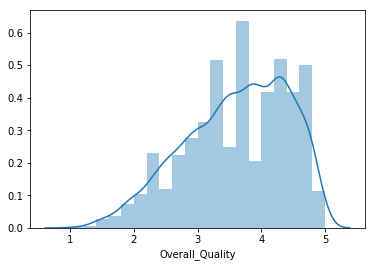

In [24]:
# PLOTTING DV (Overall_Quality) 
sns.distplot(df4['Overall_Quality'], bins = 20)

In [25]:
len(df4.State.unique())

60

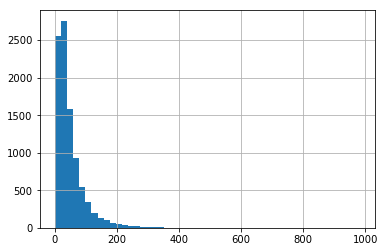

In [26]:
df4.Num_Ratings_x.hist(bins=50)

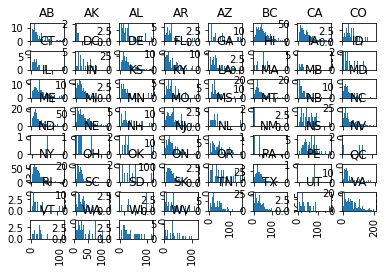

In [27]:
ax = df4[df4.Num_Ratings_x < 200].Num_Ratings_x.hist(bins = 50, by=df4.State)
plt.figure(figsize=(100, 100))



Use standard error of the mean on the mean of the overalquality. Predict mean and SEM https://en.wikipedia.org/wiki/Standard_error, can make y the vector. Or use this

https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator(Doesn't handlebinary variables well, all need to be continuous) 

choose various bys, compare distributions, run KSTest to see if they're the same distribution. If test is true test, don't extract the feature. If false, extract that feature to use in model 

Want to select feautres that demarcate where the underlying dist is coming from. Plot subset of states. Run KS on all (get matrix on similarity between states and where it fails check it out. 


In [28]:
pair1 = df4[['Difficulty', 'Grade_Received', 'Hot',
       'Overall_Quality', 'Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg']]
pair2 = df4[['Hot','Get_avg','Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg']]
pair3 = df4 [['Difficulty', 'Grade_Received', 'Hot',
       'Overall_Quality', 'Overall_Quality_State_Avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg']]


In [67]:
len(pair1.columns)

14

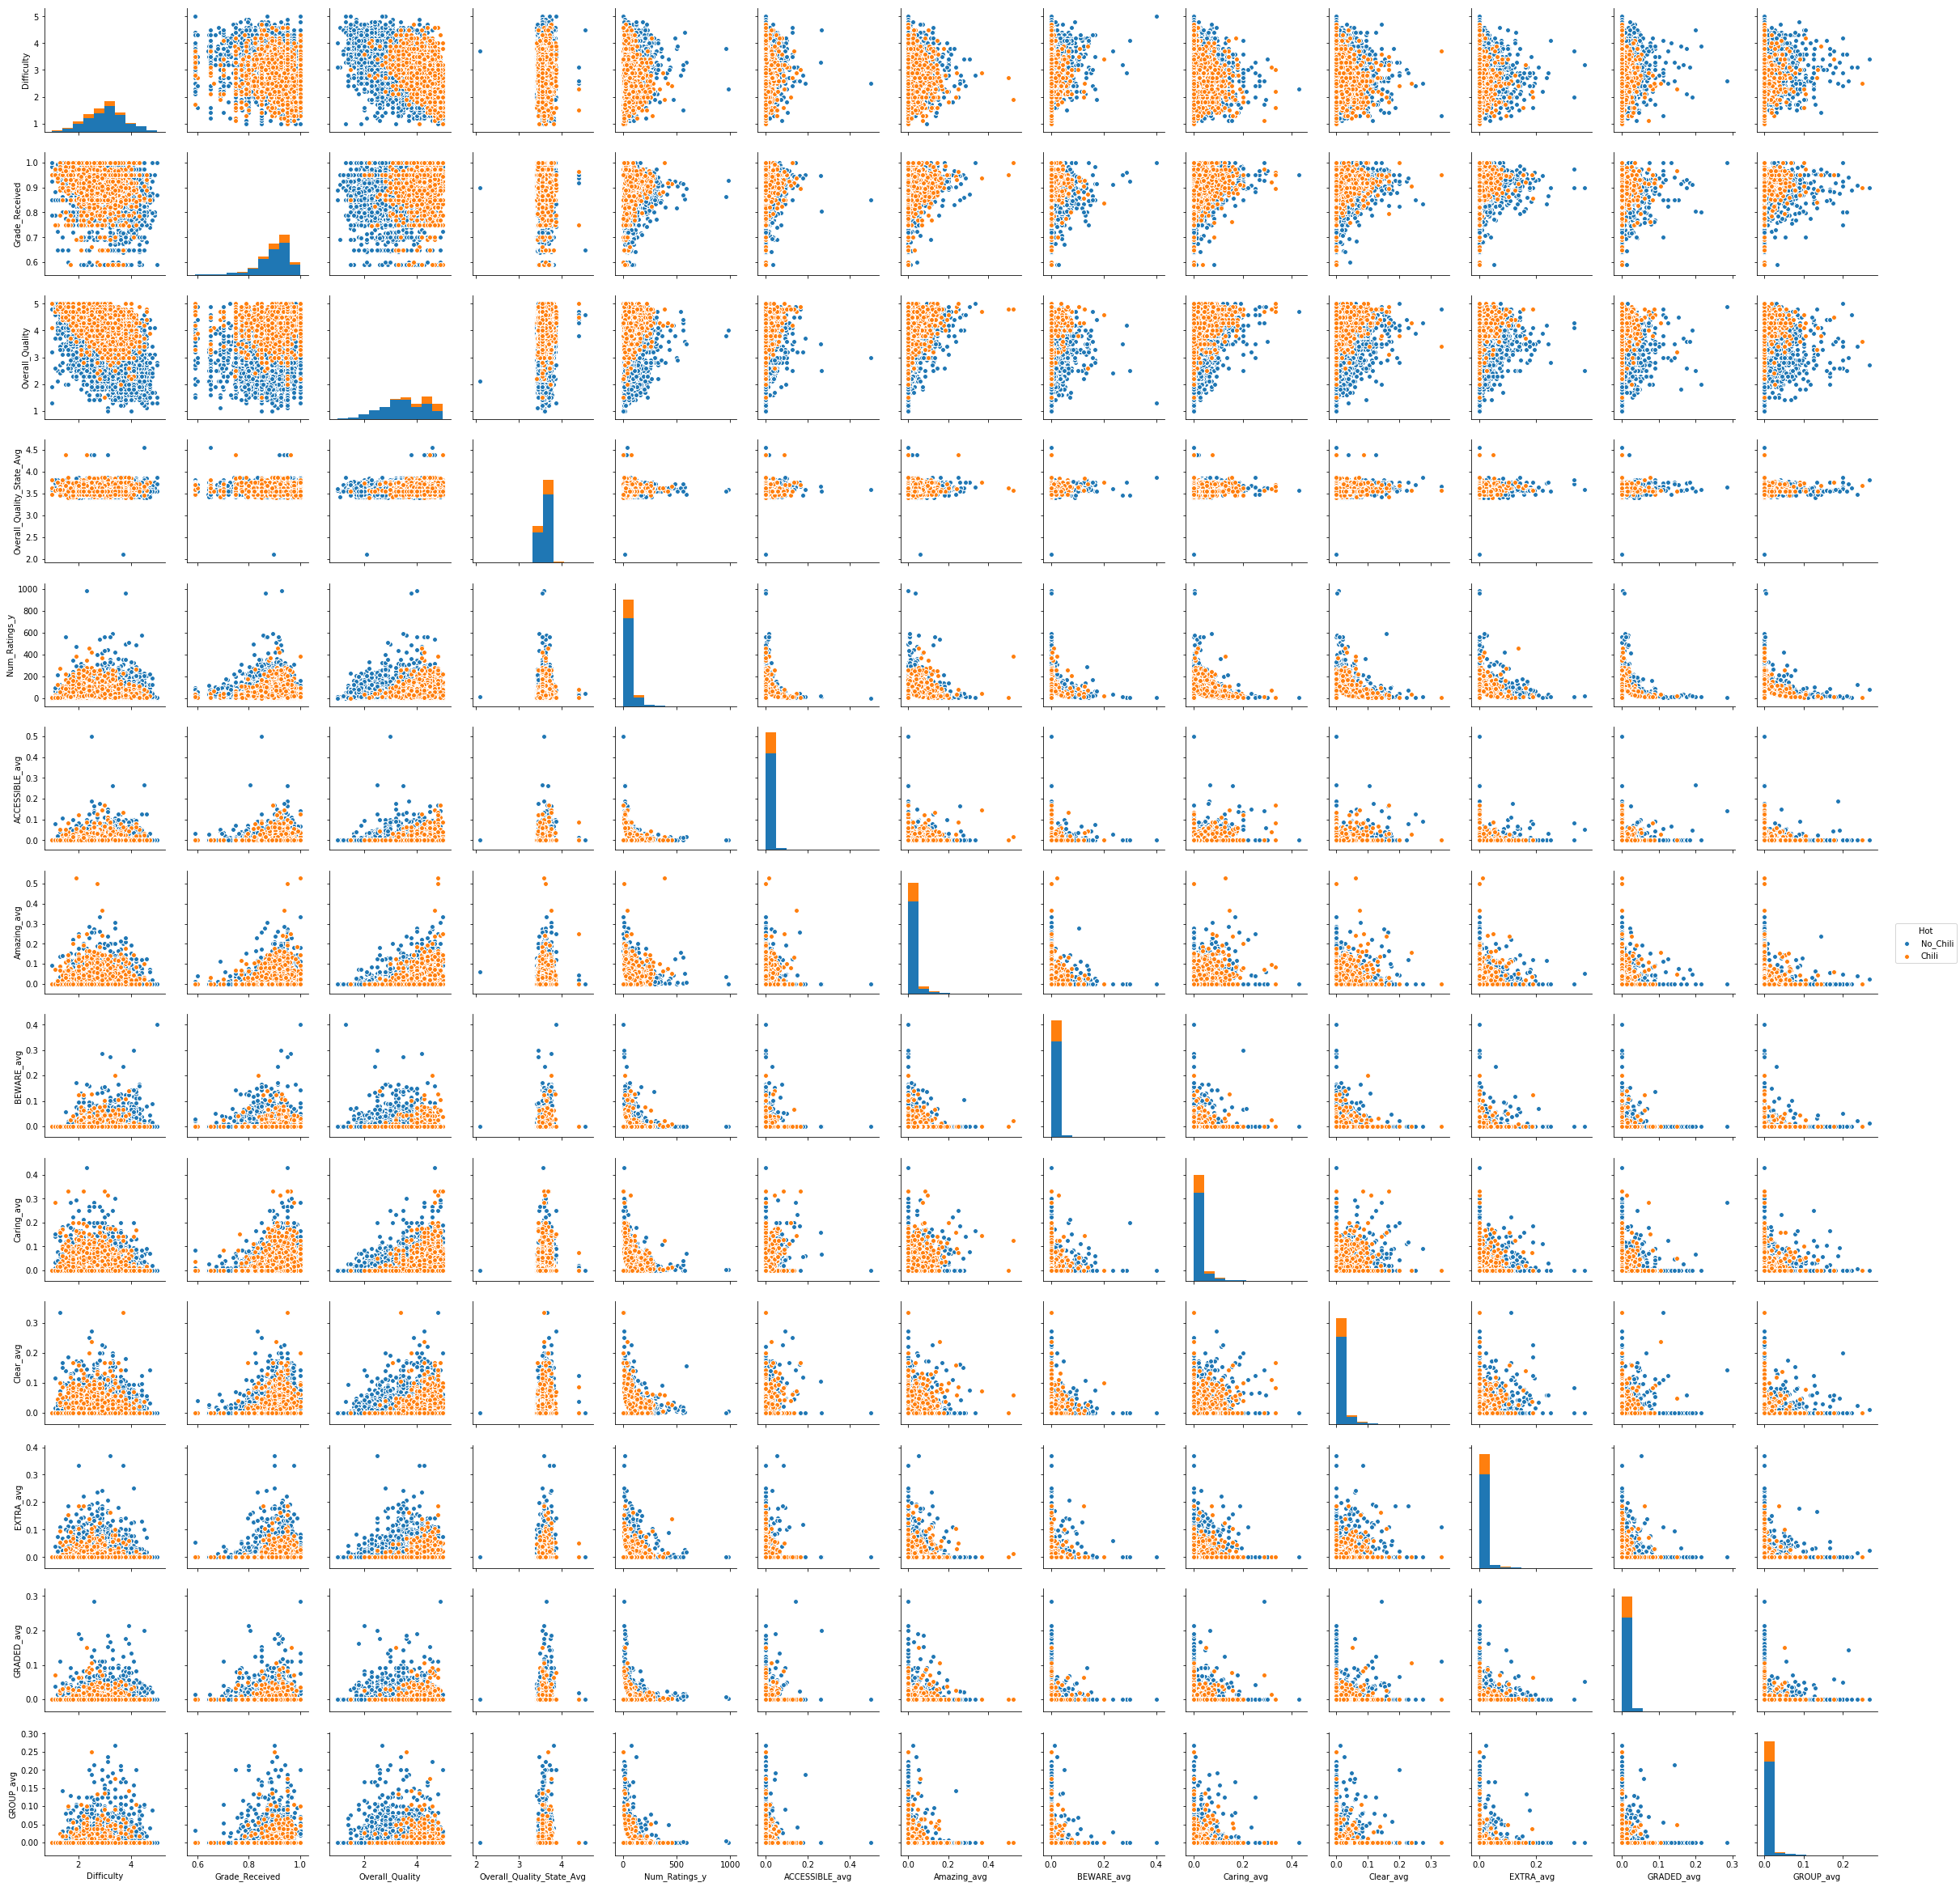

In [945]:
#pairplots of features 

plt.figure(figsize=(50, 50))
sns.pairplot(pair1, hue = 'Hot', dropna=True)


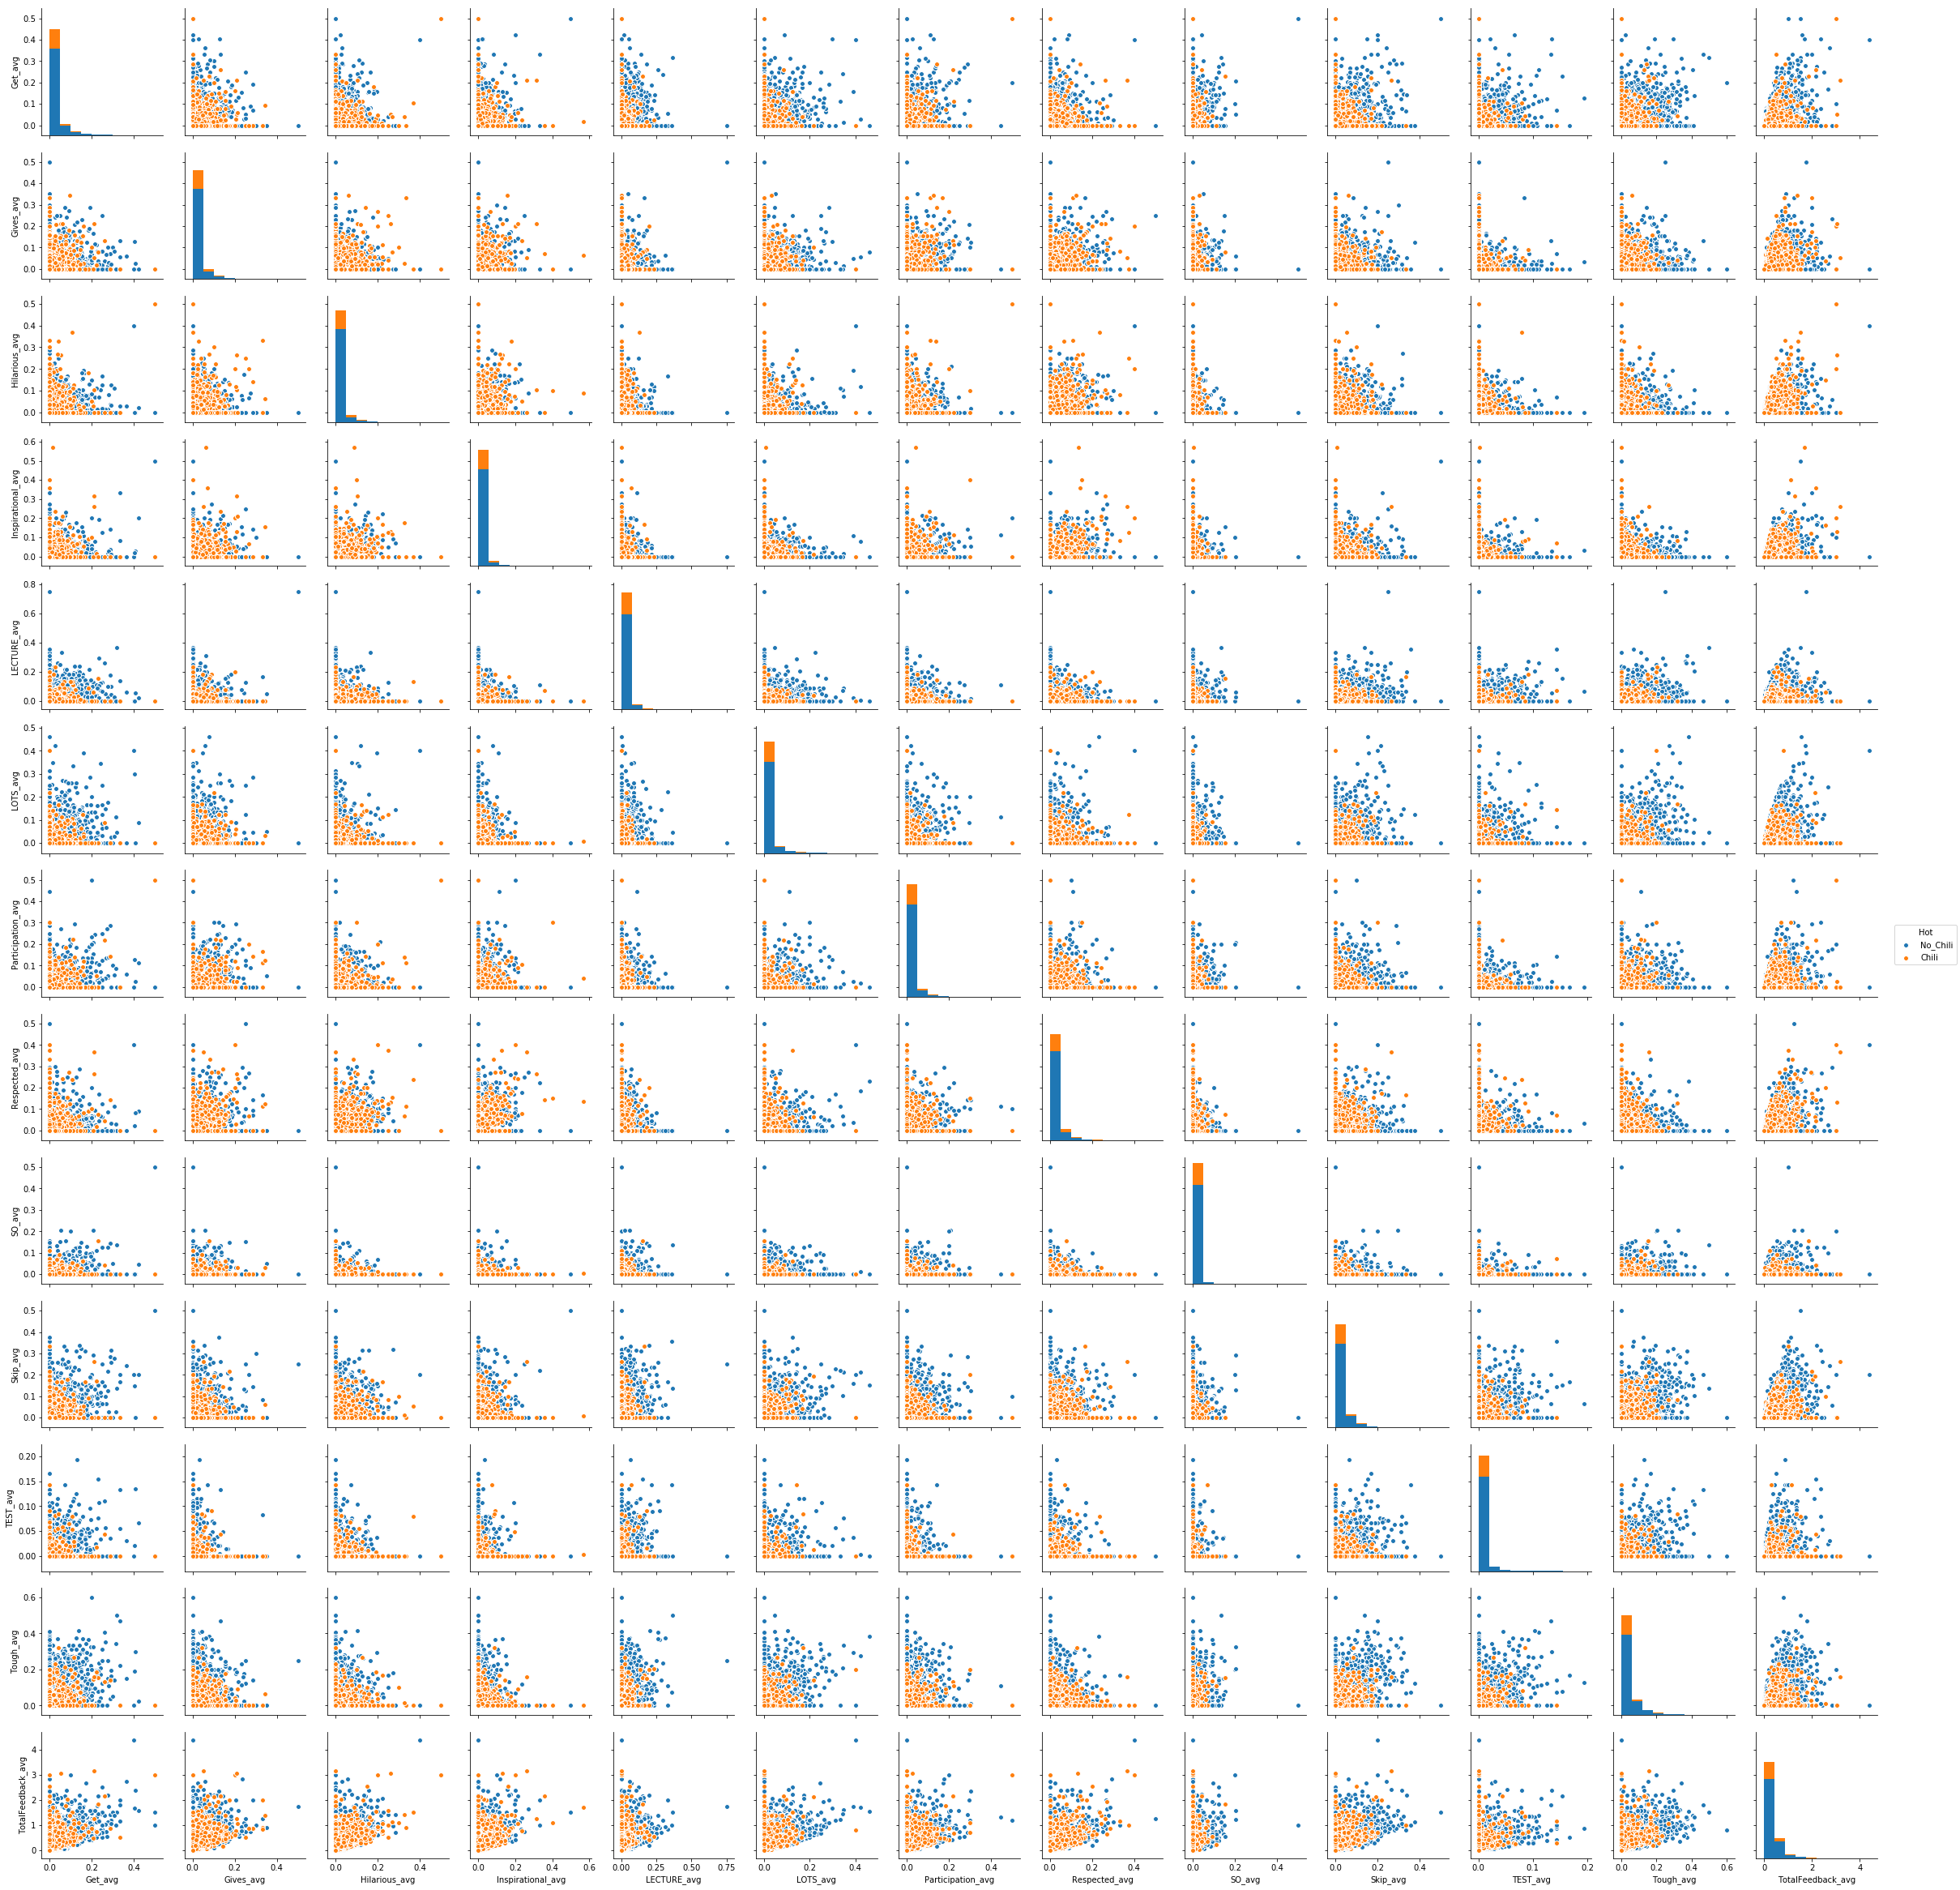

In [946]:
plt.figure(figsize=(50, 50))
sns.pairplot(pair2, hue = 'Hot', dropna=True)

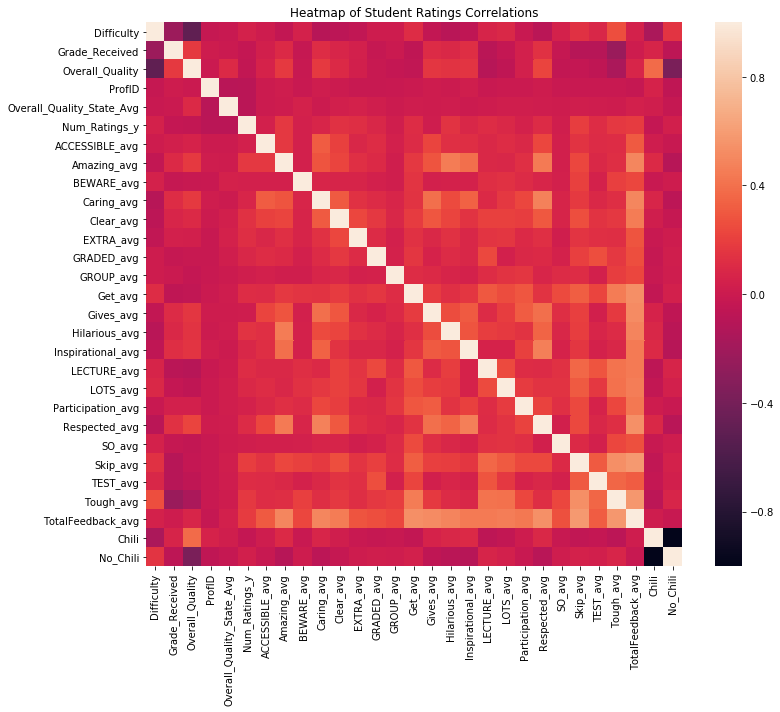

In [50]:
# check multicollinearity among features 
plt.figure(figsize=(12, 10))
sns.heatmap(df_avg.corr(), annot=False)
plt.title("Heatmap of Student Ratings Correlations")

In [51]:
models = {}

# Compare Models 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model,ensemble, tree, model_selection
from scipy import stats

In [30]:
df_avgs = df_avg.dropna()
#df3 = df3.apply(pd.to_numeric, errors='ignore')

In [31]:
X=df_avgs[['Difficulty', 'Grade_Received', 'Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili']]
y=df_avgs['Overall_Quality']

In [32]:
y_mean = df_avgs.Overall_Quality/df_avgs.Num_Ratings_y
y_mean

0        0.096429
1        0.012268
2        0.052439
3        0.106061
6        0.016279
8        0.314286
11       0.160870
12       0.204348
15       0.108333
16       0.166667
17       0.178571
19       0.117647
20       0.860000
21       0.128125
24       0.020000
27       0.372727
28       0.019681
29       0.042574
30       0.089744
33       0.102857
34       0.022703
35       0.050588
37       0.045000
38       0.037037
39       0.032117
40       0.009121
41       0.057813
42       0.012739
43       0.018405
45       0.028972
           ...   
15471    0.032143
15473    0.115625
15474    0.050000
15477    0.318182
15478    0.166667
15479    0.220000
15480    0.192308
15481    0.229412
15482    0.245455
15483    0.111111
15484    0.238462
15486    0.250000
15488    0.038095
15490    0.281818
15496    0.021951
15497    0.048000
15498    0.307143
15499    0.217647
15501    0.108824
15507    0.093548
15509    0.158333
15519    0.103125
15520    0.047541
15521    0.063636
15523    0

In [33]:
print(X.isnull().sum())

Difficulty                   0
Grade_Received               0
Overall_Quality_State_Avg    0
Num_Ratings_y                0
ACCESSIBLE_avg               0
Amazing_avg                  0
BEWARE_avg                   0
Caring_avg                   0
Clear_avg                    0
EXTRA_avg                    0
GRADED_avg                   0
GROUP_avg                    0
Get_avg                      0
Gives_avg                    0
Hilarious_avg                0
Inspirational_avg            0
LECTURE_avg                  0
LOTS_avg                     0
Participation_avg            0
Respected_avg                0
SO_avg                       0
Skip_avg                     0
TEST_avg                     0
Tough_avg                    0
TotalFeedback_avg            0
Chili                        0
No_Chili                     0
dtype: int64


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

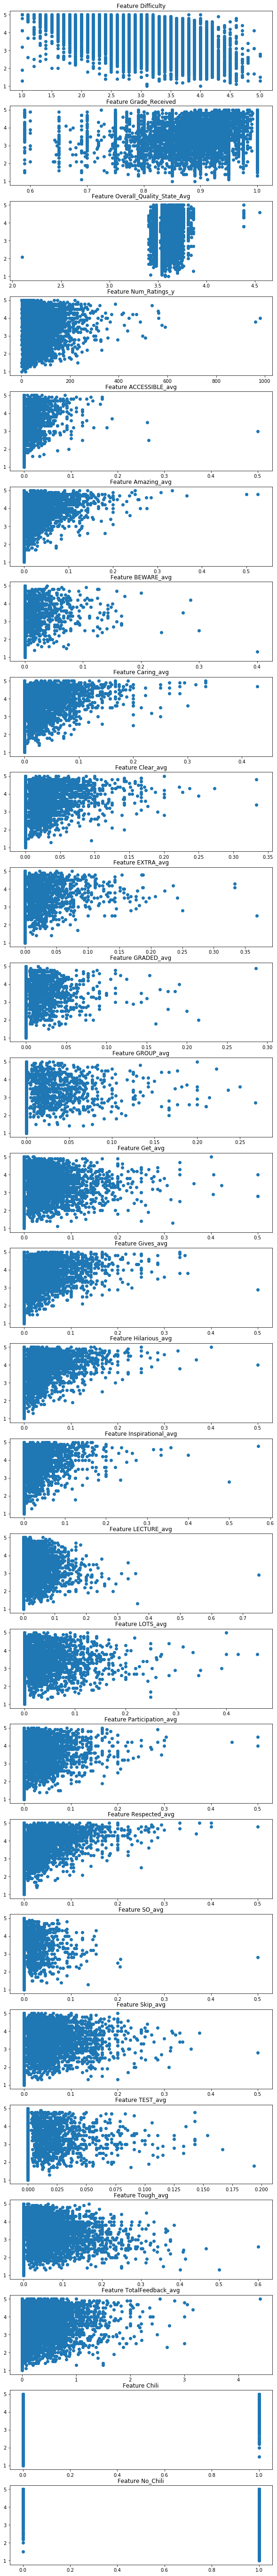

In [35]:
fig,ax = plt.subplots(ncols=1,nrows=len(X.columns),figsize=(10, 100))

for i,feature in enumerate(X):
    ax[i].scatter(X[feature],y)
    ax[i].set_title("Feature "+str(feature))

In [73]:
X,holdoutX,y,holdouty = model_selection.train_test_split(X,y,test_size = .1)

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=20)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=20)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X, y, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model: linear_model
Score: 0.449804015185

Model: ridge_model
Score: 0.449423348623

Model: lasso_model
Score: -0.000729372956816

Model: robust_regression
Score: 0.217672455234

Model: eps_insensitive
Score: -1.89787162993

Model: cart
Score: 0.414251608284

Model: extratrees
Score: 0.406727650008

Model: randomForest
Score: 0.393661098578

Model: adaboostedTrees
Score: 0.40257451191

Model: gradboostedTrees
Score: 0.487754429977



In [74]:
def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
            
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)

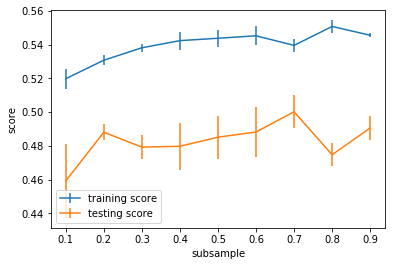

In [979]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'subsample':np.arange(.1,1,.1)})

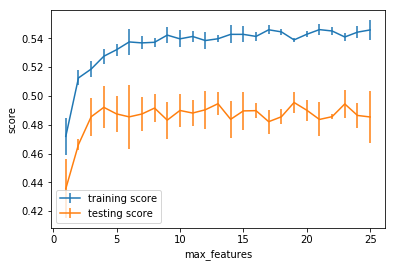

In [974]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_features':range(1,26)})

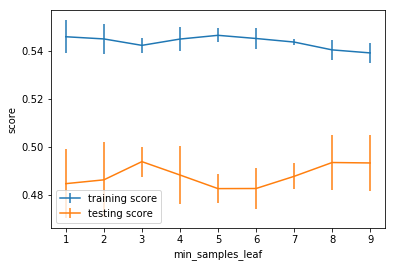

In [970]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'min_samples_leaf':range(1,10)})

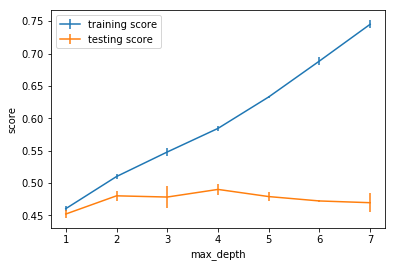

In [971]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'max_depth':range(1,8)})

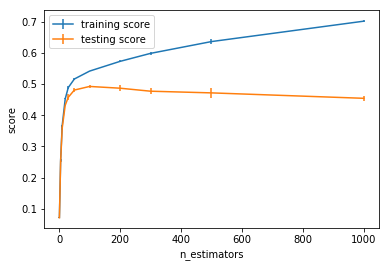

In [973]:
plot_overfit(X,y,ensemble.GradientBoostingRegressor,{'n_estimators':[1,5,10,20,30,50,100,200,300,500,1000]})

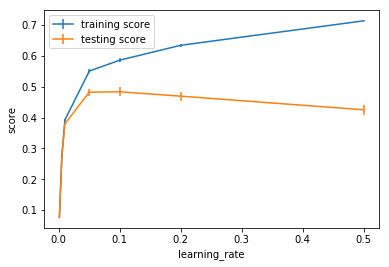

In [978]:
model = ensemble.GradientBoostingRegressor
params = {'learning_rate':[.001,.005,.01,.05,.1,.2,.5]}
param_static = {'max_depth':4}
plot_overfit(X,y,model,params,param_static=param_static)

In [55]:
from sklearn.model_selection import GridSearchCV

In [5]:
parameters = {'subsample':np.arange(.1,1,.2),
              'max_depth':[4,5],
              'learning_rate':np.arange(.001,.5,.02),
              'n_estimators':np.arange(100,500)}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train,y_train)

NameError: name 'ensemble' is not defined

# Dummy Code States and rerun


In [ ]:
df_avg = df3[['City', 'Difficulty', 'Grade_Received', 'Hot',
       'Overall_Quality', 'ProfID', 'School', 'State', 'Tags','Overall_Quality_State_Avg', 'Num_Ratings_y',
       'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg', 'Caring_avg',
       'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg', 'Get_avg',
       'Gives_avg', 'Hilarious_avg', 'Inspirational_avg', 'LECTURE_avg',
       'LOTS_avg', 'Participation_avg', 'Respected_avg', 'SO_avg', 'Skip_avg',
       'TEST_avg', 'Tough_avg', 'TotalFeedback_avg', 'Chili', 'No_Chili']]

In [ ]:
# dummy codes 'Hot' and adds it to dataframe
df_right=pd.get_dummies(df_avgs['State'])
df_states = pd.merge(df_avgs, df_right, how='outer', on = None, right_index = True, left_index = True)

In [ ]:
df_states.head()

In [988]:
df_states.columns

Index(['City', 'Difficulty', 'Grade_Received', 'Hot', 'Overall_Quality',
       'ProfID', 'School', 'State', 'Tags', 'Overall_Quality_State_Avg',
       'Num_Ratings_y', 'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg',
       'Caring_avg', 'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg',
       'Get_avg', 'Gives_avg', 'Hilarious_avg', 'Inspirational_avg',
       'LECTURE_avg', 'LOTS_avg', 'Participation_avg', 'Respected_avg',
       'SO_avg', 'Skip_avg', 'TEST_avg', 'Tough_avg', 'TotalFeedback_avg',
       'Chili', 'No_Chili', 'AB', 'AK', 'AL', 'AR', 'AZ', 'BC', 'CA', 'CO',
       'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MB', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NB', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NL', 'NM', 'NS', 'NV', 'NY', 'OH', 'OK', 'ON',
       'OR', 'PA', 'PE', 'QC', 'RI', 'SC', 'SD', 'SK', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV'],
      dtype='object')

In [57]:
X=df_states[['Difficulty', 'Grade_Received', 
       'Num_Ratings_y', 'ACCESSIBLE_avg', 'Amazing_avg', 'BEWARE_avg',
       'Caring_avg', 'Clear_avg', 'EXTRA_avg', 'GRADED_avg', 'GROUP_avg',
       'Get_avg', 'Gives_avg', 'Hilarious_avg', 'Inspirational_avg',
       'LECTURE_avg', 'LOTS_avg', 'Participation_avg', 'Respected_avg',
       'SO_avg', 'Skip_avg', 'TEST_avg', 'Tough_avg', 'TotalFeedback_avg',
       'Chili', 'No_Chili', 'AB', 'AK', 'AL', 'AR', 'AZ', 'BC', 'CA', 'CO',
       'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MB', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NB', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NL', 'NM', 'NS', 'NV', 'NY', 'OH', 'OK', 'ON',
       'OR', 'PA', 'PE', 'QC', 'RI', 'SC', 'SD', 'SK', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV']]
y=df_states['Overall_Quality']

NameError: name 'df_states' is not defined

In [991]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [56]:
X,holdoutX,y,holdouty = model_selection.train_test_split(X,y,test_size = .1)

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=20)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=20)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X, y, n_jobs=2)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

NameError: name 'X' is not defined

In [54]:
parameters = {'subsample':np.arange(.1,1,.2),
              'max_depth':np.arange(2,5),
              'learning_rate':np.arange(.001,.5,.02),
              'n_estimators':np.arange(100,500)}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=4, verbose=1)
grid_search.fit(X_train,y_train)

NameError: name 'GridSearchCV' is not defined

In [995]:
from sklearn.metrics import mean_squared_error


In [ ]:
parameters = {'subsample':np.arange(.1,1,.2),
              'max_depth':[4,5],
              'learning_rate':np.arange(.001,.5,.02),
              'n_estimators':np.arange(100,500)}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=4, verbose=1)
grid_search.fit(X_train,y_train)

In [996]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.3345


AttributeError: 'DataFrame' object has no attribute 'feature_names'

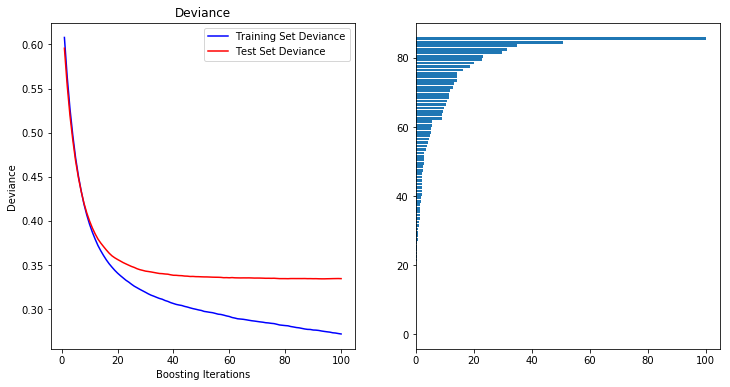

In [999]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_avgs.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

For examining coeffients 
https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/